In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, CategoricalAccuracy
from sklearn.model_selection import train_test_split

2024-06-11 11:45:01.254233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 11:45:01.254329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 11:45:01.375006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!wget https://storage.googleapis.com/sweple.appspot.com/dataset229.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-11 11:45:43--  https://storage.googleapis.com/sweple.appspot.com/dataset229.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 74.125.134.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 387892589 (370M) [application/zip]
Saving to: 'dataset229.zip'

dataset229.zip      100%[===================>] 369.92M  12.2MB/s    in 32s     

2024-06-11 11:46:17 (11.6 MB/s) - 'dataset229.zip' saved [387892589/387892589]



In [5]:
import zipfile

current_dir = os.getcwd()
local_zip = './dataset229.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
# Split dataset into training and testing sets

dataset_dir = "dataset"
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for i in os.listdir(dataset_dir):
    sub_dir = os.listdir(os.path.join(dataset_dir, i))
    for j in sub_dir:
        cat_dir = os.path.join(os.path.join(dataset_dir, i), j)

        if os.path.isdir(cat_dir):
            os.makedirs(os.path.join(train_dir, j), exist_ok=True)
            os.makedirs(os.path.join(test_dir, j), exist_ok=True)

            images = os.listdir(cat_dir)

            train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

            for image in train_images:
                shutil.move(os.path.join(cat_dir, image), os.path.join(train_dir, j, image))
            for image in test_images:
                shutil.move(os.path.join(cat_dir, image), os.path.join(test_dir, j, image))

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

Found 44472 images belonging to 283 classes.
Found 14555 images belonging to 283 classes.


In [8]:
classes_train = train_generator.class_indices
classes_test = test_generator.class_indices
print("Training samples:", train_generator.samples)
print("Testing samples:", test_generator.samples)

Training samples: 44472
Testing samples: 14555


In [ ]:
print("Class Indicate", train_generator.class_indices)

In [22]:
# Create a MirroredStrategy to use both GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()

# Compile the model under the MirroredStrategy
with mirrored_strategy.scope():
    # Load pre-trained InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dense(len(classes_train), activation='softmax')(x)

    # Create the new model
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    
    model.compile(optimizer=Adam(),
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=[CategoricalAccuracy()])
    
    history = model.fit(train_generator,
          epochs=20,
          validation_data=test_generator,
          verbose=1)


Epoch 1/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 640s 449ms/step - categorical_accuracy: 0.1512 - loss: 4.3331 - val_categorical_accuracy: 0.6737 - val_loss: 1.0970
Epoch 2/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 556s 409ms/step - categorical_accuracy: 0.6220 - loss: 1.2887 - val_categorical_accuracy: 0.7865 - val_loss: 0.6533
Epoch 3/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 593s 437ms/step - categorical_accuracy: 0.7196 - loss: 0.8926 - val_categorical_accuracy: 0.8324 - val_loss: 0.4833
Epoch 4/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 589s 434ms/step - categorical_accuracy: 0.7643 - loss: 0.7264 - val_categorical_accuracy: 0.8669 - val_loss: 0.3972
Epoch 5/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 556s 409ms/step - categorical_accuracy: 0.7945 - loss: 0.6346 - val_categorical_accuracy: 0.8633 - val_loss: 0.3715
Epoch 6/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 563s 415ms/step - categorical_accuracy: 0.8101 - loss: 0.5744 - val_categorical_accuracy: 0.8820 - val_loss: 0.3289
Epoch 7/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 585s 431ms

In [ ]:
# history = model.fit(train_generator,
#           epochs=20,
#           validation_data=test_generator,
#           verbose=1)

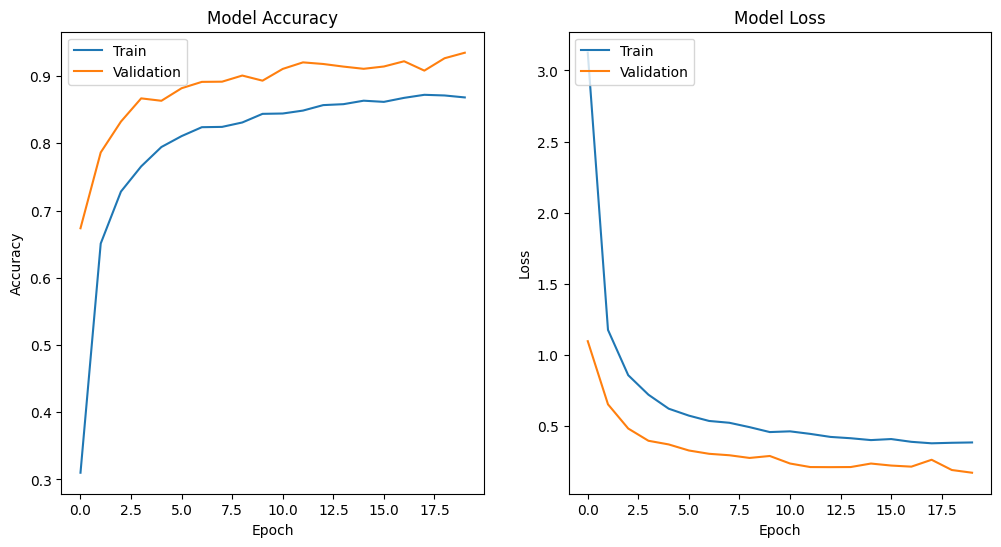

In [24]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Test the model on a new image
import io
from PIL import Image
from google.colab.files import upload
uploaded = upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

    # Load the uploaded image
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the image
    image = image.resize((200, 200))
    image_array = np.array(image) / 255.0
    image_tensor = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class = np.argmax(predictions[0])

    # Display the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")
    plt.axis('off')
    plt.show()

In [29]:
model.save('model.h5')

In [ ]:
model.export('/saved_model')

In [ ]:
import os
import tensorflow as tf
import tensorflow.lite as tflite

print(f"Current working directory: {os.getcwd()}")

try:
    model = tf.keras.models.load_model('model.h5')
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    print("Model converted to TFLite successfully")
except Exception as e:
    print(f"Error converting model to TFLite: {e}")

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
    print("TFLite model saved successfully")

Current working directory: /kaggle/working
Model loaded successfully
